# How many and-ones does a team get in a year?
David Kang. August 3, 2017

(written in Python 3.5.2)

This was an old idea I had kicking around - can we count up the number of and-ones (converted free throws making three- and four-point plays) from game flow/play-by-play data? I was originally going to scrape ESPN/NBA game log data but found that the mysportsfeed API delivers a JSON game log that works well.

Originally I wanted also to call the NBA's stats API directly but this was a little easier to work with (my suspicion is that mysportsfeed is reading and interpreting the NBA's API anyway...).

The "user" can choose the team (three character abbreviation) and the number of games (right now it's the first X number of games) from the 2016-2017 season and the ultimate output is a 'shot chart' of converted field goals and the number of total and-ones over the time span for each player.

In [13]:
# Parameters that you can use to adjust.
pickteam = "SAS"
numberofgames = 82

In [14]:
# preamble
# from bs4 import BeautifulSoup as bs
import urlopen
import urllib
import re
import pandas as pd
import numpy as np
# import datetime
# import time
# from scipy.misc import imread

%matplotlib inline
from matplotlib.patches import Circle, Rectangle, Arc
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sb

# for the api part.
import requests
import base64
import configparser

# let's be secure and keep authorization details secret.
APIKEYS = configparser.ConfigParser()
APIKEYS.read('./APIKeys.ini');

# Get the keyname (client_id?) and actual API key.
usern = APIKEYS['mysportsfeeds']['usern']
passw = APIKEYS['mysportsfeeds']['passw']

['./APIKeys.ini']

In [15]:
# Okay team by team...
team_url = "https://api.mysportsfeeds.com/v1.1/pull/nba/2016-2017-regular/team_gamelogs.json?team=" + pickteam
    
team_raw =  requests.get(
            url=team_url,
            headers={"Authorization": "Basic " + base64.b64encode('{}:{}'.format(usern,passw).encode('utf-8')).decode('ascii')}
            )

# Just in case!
print(team_raw.status_code)

# Convert to JSON
team_js = team_raw.json()

# Now we have the schedule.
team_sked = pd.DataFrame(team_js['teamgamelogs']['gamelogs'])

# Loop over the games and get the correct ID (YYYYMMDD-AWAY-HOME)
for i in range(82):
    team_sked.loc[i,'away'] = team_sked['game'][i]['awayTeam']['Abbreviation']
    team_sked.loc[i,'home'] = team_sked['game'][i]['homeTeam']['Abbreviation']
    team_sked.loc[i,'gamedate'] = team_sked['game'][i]['date'].replace("-","")

# Make it easier to read!
team_sked = team_sked.assign( gameid = team_sked['gamedate'] + "-" + team_sked['away'] + "-" + team_sked['home'])
team_sked = team_sked.drop(['game','stats','team'],1)
team_urls = team_sked.drop(['away','home','gamedate'],1)

# let's make a dataframe of the identifiers.
team_urls = team_sked.assign( gameURL = "https://api.mysportsfeeds.com/v1.1/pull/nba/2016-2017-regular/game_playbyplay.json?gameid=" + team_sked['gameid'] )

200


In [5]:
# This was for accessing all of the season's games.

# first let's get all the game IDs.
# sked_url = "https://api.mysportsfeeds.com/v1.1/pull/nba/2016-2017-regular/full_game_schedule.json"

# "Get" the API, print the status code.
# sked_raw =  requests.get(
#             url=sked_url,
#             headers={
#                 "Authorization": "Basic " + base64.b64encode('{}:{}'.format(usern,passw).encode('utf-8')).decode('ascii')
#             }
#             )

# print(sked_raw.status_code)

# Interpret the JSON and save, create a dataframe
# sked_js = sked_raw.json()
# sked_df = pd.DataFrame(sked_js['fullgameschedule']['gameentry'])

# This is if we want all of the games...
# # alright, let's access the NBA stats API game by game.
# away = sked_df.loc[: , 'awayTeam']
# home = sked_df.loc[: , 'homeTeam']

# for i in range(0,sked_df.shape[0]-1):
#     sked_df.loc[i, 'awayTeamID'] = pd.Series(away[i])['ID']
#     sked_df.loc[i, 'awayTeamAbb'] = pd.Series(away[i])['Abbreviation']
#     sked_df.loc[i, 'homeTeamID'] = pd.Series(home[i])['ID']
#     sked_df.loc[i, 'homeTeamAbb'] = pd.Series(home[i])['Abbreviation']

# sked = sked_df.loc[:, ('date','id','location','time','awayTeamID','awayTeamAbb','homeTeamID','homeTeamAbb')]


## Function: "getAndOnes"

### Let's define an And-1:
1. Free throw follows a made basket: made basket + immediate shooting foul (same timestamp)
2. For now, we'll allow the rare teammate and - 1 (and treat those separately later)
3. I suppose it's possible to have a double foul after a made shot... but we'll forget about keeping track of those.

In [16]:
# Let's make a function so that our loop can be simpler.
def getAndOnes(allplays, team):
    
    num_plays = allplays.shape[0]
    
    # we really only care about fieldGoalAttempts and 
    for i in range(num_plays):
        allplays.loc[i,'pt0'] = list(allplays['play'][i].keys())[0]
        allplays.loc[i,'pt1'] = list(allplays['play'][i].keys())[1]
        allplays.loc[i,'pt2'] = list(allplays['play'][i].keys())[2]
        allplays.loc[i,'playTime']  = allplays['play'][i]['time']
        allplays.loc[i,'q'] = int(allplays['play'][i]['quarter'])
    
    # Let's align the time correctly.
    allplays = allplays.assign(time = pd.to_datetime(allplays['playTime'], format='%M:%S').dt.time)

    # And get it in seconds.
    for i in range(num_plays): 
        allplays.loc[i,'secs'] = (int(allplays['q'][i]) - 1)*720 + allplays['time'][i].minute*60 + allplays['time'][i].second

    allplays.loc[ allplays['pt0'].isin(["quarter","time"]) , 'pt0'] = ""
    allplays.loc[ allplays['pt1'].isin(["quarter","time"]) , 'pt1'] = ""
    allplays.loc[ allplays['pt2'].isin(["quarter","time"]) , 'pt2'] = ""

    # simplify things a little
    allplays = allplays.assign(playType = allplays['pt0'] + allplays['pt1'] + allplays['pt2'])
    # drop the variables we made.
    allplays = allplays.drop(['pt0','pt1','pt2'],1)

    # These are the types.
    SorF = ['freeThrowAttempt', 'fieldGoalAttempt', 'foul']

    # we really only care about fieldGoalAttempts and 
    sfft = allplays.loc[allplays['playType'].isin(SorF),:]

    # so we gotta drop the index.
    sfft = sfft.reset_index(drop=True)

    num_sfft = sfft.shape[0]

    for i in range(num_sfft): 
        if sfft['playType'][i] == "freeThrowAttempt":
            sfft.loc[i,'fTatt']     = int( sfft['play'][i][sfft['playType'][i]]['totalAttempts'] )
            sfft.loc[i,'fTshooter'] = int( sfft['play'][i][sfft['playType'][i]]['shootingPlayer']['ID'] )
            sfft.loc[i,'fTmade']    = int( sfft['play'][i][sfft['playType'][i]]['outcome'] == "SCORED" )
            if type(team) is str:
                sfft.loc[i,'fTteam'] = int( sfft['play'][i][sfft['playType'][i]]['teamAbbreviation'] == team )
            else:
                sfft.loc[i,'fTteam']    = ''
        elif sfft['playType'][i] == "fieldGoalAttempt":
            sfft.loc[i,'fGmade']    = int( sfft['play'][i][sfft['playType'][i]]['outcome'] == "SCORED" )
            sfft.loc[i,'fGval']     = int( sfft['play'][i][sfft['playType'][i]]['Points'] )
            sfft.loc[i,'fGshooter'] = int( sfft['play'][i][sfft['playType'][i]]['shootingPlayer']['ID'] )
            try: 
                sfft.loc[i,'fGlocX']    = int( sfft['play'][i][sfft['playType'][i]]['shotLocation']['x'] ) 
                sfft.loc[i,'fGlocY']    = int( sfft['play'][i][sfft['playType'][i]]['shotLocation']['y'] ) - 250
            except:
                sfft.loc[i,'fGlocX'] = np.NaN
                sfft.loc[i,'fGlocY'] = np.NaN
            sfft.loc[i,'fGtype']    = ( sfft['play'][i][sfft['playType'][i]]['shotType'] )
            if type(team) is str:
                sfft.loc[i,'fGteam']    = int( sfft['play'][i][sfft['playType'][i]]['teamAbbreviation'] == team )
            else:
                sfft.loc[i,'fGteam']    = ''
        elif sfft['playType'][i] == "foul":
            # We're interested in shooting fouls since techs can confuse things...
            sfft.loc[i,'fLtype']    = int( sfft['play'][i][sfft['playType'][i]]['foulType'] == "S.FOUL" )
        
    # Make the dataset a little neater...
    sfft = sfft.drop(['play','playTime','playType'],1)

    # Hmm... locations here are absolute. So we have to figure out home/away.
    sfft = sfft.assign( locX = (sfft['fGlocX'])*(sfft['fGlocX'] < 470) + (940 - sfft['fGlocX'])*(sfft['fGlocX'] >= 470) - 470 )

    # Let's flatten by time.
    candidates = sfft.groupby(['gameno','q','secs'], as_index=False).sum()

    # And-ones happen when there is a field goal made and a FT made at the same time period... and not a technical foul?
    andones = candidates.loc[ (candidates['fTatt'] == 1) & (candidates['fGmade'] == 1 ) & ( candidates['fLtype'] == 1) , :]
    
    # How many team and-ones are there?
    andones = andones.assign( teammate = andones['fGshooter'] != andones['fTshooter'])
    
    # Restrict to the team you're interested in... if there is no team then you pick all.
    if type(team) is str:
        andones = andones.loc[ (andones['fGteam'] == 1) | (andones['fTteam'] == 1)]

    return andones

### Now we loop over the chosen number of games

We make a dataframe called "andone_season" that represents your piece of the season for the team you're interested in.

In [17]:
# Now let's loop over the entire season and pick up all of the And-1s from the year.
andone_season = pd.DataFrame()

# Loop over games... the number of games parameter is chosen above.
for i in range(numberofgames):
    team_games =  requests.get(
                url=team_urls['gameURL'][i],
                headers={"Authorization": "Basic " + base64.b64encode('{}:{}'.format(usern,passw).encode('utf-8')).decode('ascii')}
                )

    print(team_games.status_code)
    print("Game " + str(i+1) + ": " + team_sked['gameid'][i])

    game_js = team_games.json()

    # Make sure you get the play data.
    allplays = pd.DataFrame(game_js['gameplaybyplay']['plays'])
    allplays = allplays.assign( gameno = i )

    # Call the function and get all of the and-ones...
    andones = getAndOnes(allplays,pickteam)
    
    # Append after each game to make a season-long dataset.
    andone_season = andone_season.append(andones,ignore_index=True)
    

200
Game 1: 20161025-SAS-GSW
200
Game 2: 20161027-SAS-SAC
200
Game 3: 20161029-NOP-SAS
200
Game 4: 20161030-SAS-MIA
200
Game 5: 20161101-UTA-SAS
200
Game 6: 20161104-SAS-UTA
200
Game 7: 20161105-LAC-SAS
200
Game 8: 20161109-HOU-SAS
200
Game 9: 20161111-DET-SAS
200
Game 10: 20161112-SAS-HOU
200
Game 11: 20161114-MIA-SAS
200
Game 12: 20161116-SAS-SAC
200
Game 13: 20161118-SAS-LAL
200
Game 14: 20161121-DAL-SAS
200
Game 15: 20161123-SAS-CHA
200
Game 16: 20161125-SAS-BOS
200
Game 17: 20161126-SAS-WAS
200
Game 18: 20161129-ORL-SAS
200
Game 19: 20161130-SAS-DAL
200
Game 20: 20161202-WAS-SAS
200
Game 21: 20161205-SAS-MIL
200
Game 22: 20161206-SAS-MIN
200
Game 23: 20161208-SAS-CHI
200
Game 24: 20161210-BRO-SAS
200
Game 25: 20161214-BOS-SAS
200
Game 26: 20161215-SAS-PHX
200
Game 27: 20161218-NOP-SAS
200
Game 28: 20161220-SAS-HOU
200
Game 29: 20161222-SAS-LAC
200
Game 30: 20161223-SAS-POR
200
Game 31: 20161225-CHI-SAS
200
Game 32: 20161228-PHX-SAS
200
Game 33: 20161230-POR-SAS
200
Game 34: 201701

In [18]:
# Now, let's identify these players.
hoff = pd.DataFrame(team_js['teamgamelogs']['gamelogs'])

# player URL
player_url = "https://api.mysportsfeeds.com/v1.1/pull/nba/2016-2017-regular/cumulative_player_stats.JSON?playerstats=2PA,2PM,3PA,3PM,FTA,FTM"

# You can pass a parameter with the teamname.
team_player =  requests.get(
                url=player_url,
                params = {"team": pickteam},
                headers={"Authorization": "Basic " + base64.b64encode('{}:{}'.format(usern,passw).encode('utf-8')).decode('ascii')}
            )

# Again, just in case.
print(team_player.status_code)

# Construct the dataframes!
team_player = team_player.json()
team_player = pd.DataFrame(team_player['cumulativeplayerstats']['playerstatsentry'])
players = pd.DataFrame(team_player['player'])
playerstats = pd.DataFrame(team_player['stats'])

# How many players?
teamsize = players.shape[0]

# Loop through player characteristics and build a dataframe.
for i in range(teamsize): 
    try:
        players.loc[i,'jersey'] = players['player'][i]['JerseyNumber']
    except:
        # A couple players have no jersey numbers?
        players.loc[i,'jersey'] = -1
    players.loc[i,'position'] = players['player'][i]['Position']
    players.loc[i,'ID'] = int(players['player'][i]['ID'])
    players.loc[i,'lastname'] = players['player'][i]['LastName']

# Make it neater
players = players.drop(['player'],1)

# Let's merge on the season data:
andoneplayer2 = andone_season.merge(players, left_on='fTshooter', right_on='ID')

# How many And-ones?
howmany = andoneplayer2.groupby(['ID','lastname','jersey']).size().reset_index(name="andones")
howmany = howmany.sort_values(by='andones',ascending=False)

# We concatenate the player name with how many and-ones (for the legend).
for i in range(howmany.shape[0]):
    howmany.loc[i,'last2'] = howmany['lastname'][i] + "   (" + str(howmany['andones'][i]) + ")"
    
# Merge together...
andoneplayer = andoneplayer2.merge(howmany, on=['ID'])

200


#### Plotting

For the plotting part, first we define a function drawing a half court (we'll fold all of the possessions to one side).

This next function was ripped from http://savvastjortjoglou.com/nba-shot-sharts.html.
But... I added some nice colorful pictures.

In [19]:
# Shamelessly adapted from http://savvastjortjoglou.com/nba-shot-sharts.html (and rotated to landscape...)
def draw_court(ax=None, color='black', lw=2, outer_lines=False):
    # If an axes object isn't provided to plot onto, just get current one
    if ax is None:
        ax = plt.gca()

    outer_box = Rectangle((-470, -80), 190, 160, linewidth=lw, color=color, fill=False)

    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = Arc((-417.5, 0), 80, 80, theta1=270, theta2=90, linewidth=lw, color=color)

    # Three point line
    # Create the side 3pt lines, they are 14ft long before they begin to arc
    corner_three_a = Rectangle((-470, 220), 140, 0, linewidth=lw, color=color)
    corner_three_b = Rectangle((-470, -220), 140, 0, linewidth=lw, color=color)
    # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
    # I just played around with the theta values until they lined up with the threes
    three_arc = Arc((-417.5, 0), 475, 475, theta1=292, theta2=68, linewidth=lw, color=color)

    # List of the court elements to be plotted onto the axes
    court_elements = [outer_box, restricted, corner_three_a, corner_three_b, three_arc]

    if outer_lines:
        # Draw the half court line, baseline and side out bound lines
        outer_lines = Rectangle((-250, -47.5), 500, 470, linewidth=lw,
                                color=color, fill=False)
        court_elements.append(outer_lines)

    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)

    return ax

### Plotting

This plots the shot chart - each player has a different color and the number of season and-ones is in the 

(-470, 0)

(-250, 250)

Text(0.5,0.98,'And Ones in 2016-2017 Season')

Text(0.5,1,'Team: SAS, Number of Games: 82')

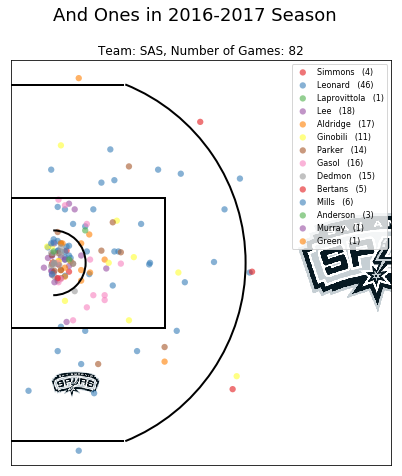

In [20]:
# Number of appropriate plays in a season:
andone_num = andoneplayer.shape[0]

plt.figure(figsize=(7,7.45))

# Unique category labels: 'D', 'F', 'G', ...
color_labels = andoneplayer['ID'].unique()
name_labels = andoneplayer['last2'].unique()

# List of RGB triplets
rgb_values = sb.color_palette("Set1", 17)

# Map label to RGB
color_map = dict(zip(color_labels, rgb_values))

# Count the total number.
numandones = andoneplayer.shape[0]
labels = [andoneplayer['last2'][i] for i in range(numandones)]

# We'll map the scatter by player
for i in range(andoneplayer['last2'].unique().shape[0]):
    andonesforhim = andoneplayer.loc[ (andoneplayer['last2'] == name_labels[i]) , : ]
    scatter = plt.scatter(andonesforhim.locX, andonesforhim.fGlocY, 
                      c=andonesforhim['ID'].map(color_map), 
                      alpha=0.6, s=40, edgecolors='none', label= name_labels[i])

draw_court(outer_lines=False)

plt.xlim(-470,0)
plt.ylim(-250,250)

# I think these are the only two weird cases.
if pickteam == "OKL":
    teamname = "OKC"
elif pickteam == "BRO":
    teamname = "BKN"
else:
    teamname = pickteam

# let's rip some logos from the internet (sorry espn and yahoo)
imgurl = "http://a.espncdn.com/combiner/i?img=/i/teamlogos/nba/500/" + teamname + ".png"
img2   = "http://l.yimg.com/xe/i/us/sp/v/nba/teams/83/70x70/" + teamname.lower() + ".png"
f = urllib.request.urlopen(imgurl)
g = urllib.request.urlopen(img2)

# plot them on our half court.
a = plt.imread(f)
b = plt.imread(g)
plt.imshow(a, zorder=0, extent=[-120, 120, -120, 120])
plt.imshow(b, origin = 'lower', zorder=0, extent=[-420, -360, -120, -180])

# Clean up the axes.
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    left ='off',
    labelleft ='off',
    top='off',         # ticks along the top edge are off
    labelbottom='off') # labels along the bottom edge are off

leg = plt.legend(fontsize=8, frameon=True)

frame = leg.get_frame()
frame.set_facecolor('white')

plt.suptitle("And Ones in 2016-2017 Season", fontsize = 18)
plt.title("Team: " + pickteam + ", Number of Games: " + str(numberofgames))

# Plot
# plt.show()

plt.savefig( pickteam + "_" + str(numberofgames) + "games.png")

#### Other stuff

Things I had wanted to do:
1. Are there more home vs. away converted and-ones (prevalence of favorable calls, better FG/FT percentage at home vs. away?)
2. The four-point-play prowess of certain players is noted. Is there a notable (statistically significantly different) group of players that convert +1 plays better than others? Is this a skill that can be developed?
3. Does the defender matter (e.g., are and-ones more likely when the fouler is a help defender?)
4. Are there more converted and-ones when the opponent is coming off of a back-to-back? Do you convert more and-ones when you are better rested?
5. Is FT percentage affected after getting fouled?
6. Can you develop any evidence from game flow data about a player's willingness (eagerness?) to try and get fouled (the James Harden effect)?